# Intraday Momentum

The genesis of this paper is from http://www.smallake.kr/wp-content/uploads/2015/01/SSRN-id2440866.pdf, which relates the first half hour of trading to the last half hour of trading. We will seek to replicate the results for the EEM Index (MSCI Emerging Markets), before exploring other local ETFs and Futures such as Hang Seng Tracker Fund, China A50 Index, MSCI Taiwan ETF. 

In [1]:
# We hate warnings
import warnings
warnings.simplefilter('ignore')

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
import math
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm

In [2]:
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def create_custom_tear_sheet(returns, positions=None,
                              transactions=None,
                              live_start_date=None,
                              cone_std=(1.0, 1.5, 2.0),
                              benchmark_rets=None,
                              bootstrap=False,
                              turnover_denom='AGB',
                              header_rows=None,
                              return_fig=False):
    """
    Generate a number of plots for analyzing a strategy's returns.
    - Fetches benchmarks, then creates the plots on a single figure.
    - Plots: rolling returns (with cone), rolling beta, rolling sharpe,
        rolling Fama-French risk factors, drawdowns, underwater plot, monthly
        and annual return plots, daily similarity plots,
        and return quantile box plot.
    - Will also print the start and end dates of the strategy,
        performance statistics, drawdown periods, and the return range.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - See full explanation in create_full_tear_sheet.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    benchmark_rets : pd.Series, optional
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    returns = returns[returns.index > benchmark_rets.index[0]]

    pf.show_perf_stats(returns, benchmark_rets)

    pf.show_worst_drawdown_periods(returns)

    # If the strategy's history is longer than the benchmark's, limit strategy
    if returns.index[0] < benchmark_rets.index[0]:
        returns = returns[returns.index > benchmark_rets.index[0]]

    vertical_sections = 12

    if live_start_date is not None:
        vertical_sections += 1
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    if bootstrap:
        vertical_sections += 1

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_rolling_returns = plt.subplot(gs[:2, :])

    i = 2
    ax_rolling_returns_vol_match = plt.subplot(gs[i, :],
                                               sharex=ax_rolling_returns)
    i += 1
    ax_rolling_returns_log = plt.subplot(gs[i, :],
                                         sharex=ax_rolling_returns)
    i += 1
    ax_returns = plt.subplot(gs[i, :],
                             sharex=ax_rolling_returns)
    i += 1
    ax_rolling_beta = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_volatility = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_sharpe = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_drawdown = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_underwater = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_monthly_heatmap = plt.subplot(gs[i, 0])
    ax_annual_returns = plt.subplot(gs[i, 1])
    ax_monthly_dist = plt.subplot(gs[i, 2])
    i += 1
    ax_return_quantiles = plt.subplot(gs[i, :])
    i += 1

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns)
    ax_rolling_returns.set_title(
        'Cumulative returns')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=None,
        volatility_match=True,
        legend_loc=None,
        ax=ax_rolling_returns_vol_match)
    ax_rolling_returns_vol_match.set_title(
        'Cumulative returns volatility matched to benchmark')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        logy=True,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns_log)
    ax_rolling_returns_log.set_title(
        'Cumulative returns on logarithmic scale')

    pf.plot_returns(
        returns,
        live_start_date=live_start_date,
        ax=ax_returns,
    )
    ax_returns.set_title(
        'Returns')

    pf.plot_rolling_beta(
        returns, benchmark_rets, ax=ax_rolling_beta)

    pf.plot_rolling_volatility(
        returns, factor_returns=benchmark_rets, ax=ax_rolling_volatility)

    pf.plot_rolling_sharpe(
        returns, ax=ax_rolling_sharpe)

    # Drawdowns
    pf.plot_drawdown_periods(
        returns, top=5, ax=ax_drawdown)

    pf.plot_drawdown_underwater(
        returns=returns, ax=ax_underwater)

    pf.plot_monthly_returns_heatmap(returns, ax=ax_monthly_heatmap)
    pf.plot_annual_returns(returns, ax=ax_annual_returns)
    pf.plot_monthly_returns_dist(returns, ax=ax_monthly_dist)

    pf.plot_return_quantiles(
        returns,
        live_start_date=live_start_date,
        ax=ax_return_quantiles)

    if bootstrap:
        ax_bootstrap = plt.subplot(gs[i, :])
        pf.plot_perf_stats(returns, benchmark_rets,
                                 ax=ax_bootstrap)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


First, I would like to investigate the average daily trading volume of each 30 minute interval to determine if the opening and closing hours are more active than the rest of the day.

In [3]:
data = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\QQQ\QQQ Vol.csv', index_col=0)
data.index = pd.to_datetime(data.index, format = '%d/%m/%Y %H:%M')

In [4]:
# Adjust the data to take into account daylights savings
a = data.index[:336].shift(-1, 'H')
b = data.index[336:]
data.index = a.append(b)

In [5]:
hour = [21, 22, 23, 0, 1, 2, 3]
min = [0, 30]
full_time = [(x, y) for x in hour for y in min][1:]

In [6]:
avg_vol = pd.Series()

for t in full_time:
     avg_vol[datetime.time(t[0], t[1])] = data['Volume'][data.index.time == datetime.time(t[0], t[1])].mean()

Text(0.5,1,'Average Traded Volume')

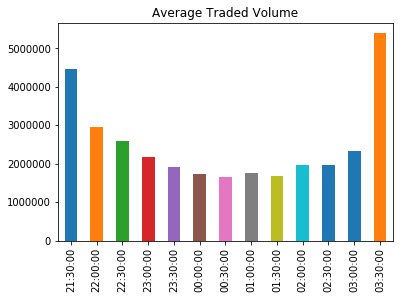

In [7]:
avg_vol.plot.bar()
plt.title('Average Traded Volume')

As expected, the opening half-hour (21:30) and the closing half-hour (03:30) are indeed more active than expected. Now, let's try to calculate the opening half-hour returns and the closing half-hour returns, before running a simple OLS regression.

To do so, we will be using the mid bid-ask data to calculate the trade prices.

In [8]:
# Read the open bid data 
open_bid = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\QQQ\Open Bid.csv', 
                       index_col=0)
open_bid.index = pd.to_datetime(open_bid.index, format = '%d/%m/%Y %H:%M')

# Read the open ask data
open_ask = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\QQQ\Open Ask.csv', 
                       index_col=0)
open_ask.index = pd.to_datetime(open_ask.index, format = '%d/%m/%Y %H:%M')

# Do a inner merge on both bid and ask for the open data
open_data = open_bid.merge(open_ask, left_index=True, right_index=True)

# Calculate the mid-price using (bid+ask)/2
open_data['Mid'] = 0.5 * (open_data['Bid'] + open_data['Ask'])

In [9]:
# Adjust the data for daylights savings
a = open_data.index[:132].shift(-1, 'H')
b = open_data.index[132:]
open_data.index = a.append(b)

In [10]:
# Read the close bid data 
close_bid = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\QQQ\Close Bid.csv', 
                       index_col=0)
close_bid.index = pd.to_datetime(close_bid.index, format = '%d/%m/%Y %H:%M')

# Read the close ask data
close_ask = pd.read_csv(r'C:\Users\Law Wen Yu\Desktop\Intraday Momentum Strategies\QQQ\Close Ask.csv', 
                       index_col=0)
close_ask.index = pd.to_datetime(close_ask.index, format = '%d/%m/%Y %H:%M')

# Do a inner merge on both bid and ask for the close data
close_data = close_bid.merge(close_ask, left_index=True, right_index=True)

# Calculate the mid-price using (bid+ask)/2
close_data['Mid'] = 0.5 * (close_data['Bid'] + close_data['Ask'])

In [11]:
# Adjust the data for daylights savings
a = close_data.index[:132].shift(-1, 'H')
b = close_data.index[132:]
close_data.index = a.append(b)

In [12]:
# Set the closing hour
closing_time = datetime.time(3, 30)

# Calculate the returns for the closing half-hour
close_ret = (close_data['Mid'][close_data.index.time == closing_time] / open_data[
    'Mid'][open_data.index.time == closing_time]) - 1
close_ret.index = close_ret.index.normalize().dropna()

In [13]:
# Set the opening hour
opening_time = datetime.time(21, 30)

# Read the close for the first half-hour open and normalize the data 
open_close = pd.DataFrame(close_data['Mid'][close_data.index.time == opening_time])
open_close.index = open_close.index.normalize()
open_close = open_close

close_close = pd.DataFrame(close_data['Mid'][close_data.index.time == closing_time])
close_close.index = close_close.index.normalize()
close_close = close_close
close_close.index = open_close.index

open_ret = open_close / close_close - 1

In [14]:
X = pd.DataFrame(index=open_ret[1:].index)

past_opening_day_ret = open_ret.shift(1).dropna()
X['Past Opening Day Ret'] = past_opening_day_ret

past_closing_day_ret = close_ret[:-1]
past_closing_day_ret.index = past_opening_day_ret.index
X['Past Closing Day Ret'] = past_closing_day_ret

a = X['Past Opening Day Ret']
b = X['Past Closing Day Ret']

y = open_ret[1:]

In [15]:
model = sm.OLS(b, a).fit()
predictions = model.predict(a)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Past Closing Day Ret   R-squared:                       0.131
Model:                              OLS   Adj. R-squared:                  0.124
Method:                   Least Squares   F-statistic:                     18.33
Date:                  Wed, 22 Aug 2018   Prob (F-statistic):           3.72e-05
Time:                          23:29:33   Log-Likelihood:                 546.33
No. Observations:                   123   AIC:                            -1091.
Df Residuals:                       122   BIC:                            -1088.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Past Opening Day Ret    -0.1066      0.025     -4.282      0.000      -0.156      -0.057
==============================================================================
Omnibus:                       19.121   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.171
Skew:                          -0.522   Prob(JB):                     1.27e-11
Kurtosis:                       5.950   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
df = pd.DataFrame()

# For our strategy, go opposite of the day open for the close, (include a 0.05% transaction cost)
df['Strat_Daily_rets'] = (-np.sign(a) * b)   
#df['Long_Strat_Daily_rets'] = (-np.sign(a) * b * (a<0).astype('int')) - 0.0005
#df['Short_Strat_Daily_rets'] = (-np.sign(a) * b * (a>0).astype('int')) - 0.0005

# Our benchmark of always going long on the closing half-hour 
df['Benchmark_rets'] = a

# Calculate the cumulative returns of our strategy
df['Strat_perc_ret'] = (1 + df.Strat_Daily_rets).cumprod() - 1
df['Benchmark_perc_ret'] = (1 + df.Benchmark_rets).cumprod() - 1

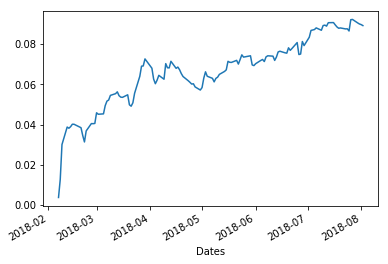

In [31]:
df['Strat_perc_ret'].plot()

In [18]:
create_custom_tear_sheet(returns=df['Strat_Daily_rets'], benchmark_rets=df['Benchmark_rets'])

Backtest months: 5


,Backtest
Annual return,8.1%
Cumulative returns,3.9%
Annual volatility,3.5%
Sharpe ratio,2.23
Calmar ratio,5.09
Stability,0.48
Max drawdown,-1.6%
Omega ratio,2.40
Sortino ratio,5.97
Skew,3.93


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.60,2018-03-27,2018-04-26,NaT,NaN
1,0.23,2018-03-13,2018-03-14,2018-03-23,9
2,0.17,2018-02-12,2018-03-05,2018-03-06,17
3,0.00,2018-02-08,2018-02-08,2018-02-08,1
4,0.00,2018-02-08,2018-02-08,2018-02-08,1


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001F2C072EA60> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1008x5184 with 13 Axes>

In [20]:
close_data[close_data.index.time == closing_time]

,Bid,Ask,Mid
Dates,,,
2018-02-07 03:30:00,162.17,162.18,162.175
2018-02-08 03:30:00,160.25,160.26,160.255
2018-02-09 03:30:00,153.52,153.55,153.535
2018-02-10 03:30:00,156.13,156.14,156.135
2018-02-13 03:30:00,159.27,159.28,159.275
2018-02-14 03:30:00,159.76,159.77,159.765
2018-02-15 03:30:00,162.33,162.34,162.335
2018-02-16 03:30:00,165.15,165.16,165.155
2018-02-17 03:30:00,165.53,165.55,165.540


## Buy & Hold

In [78]:
close_data['Mid'][-9] / open_data['Mid'][13] - 1 

0.1267928318111915